['sweing' 'finishing']
['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']

Encoded Data:
   team  targeted_productivity    smv  over_time  incentive  idle_time  \
0     8                   0.80  26.16       7080         98        0.0   
1     1                   0.75   3.94        960          0        0.0   
2    11                   0.80  11.41       3660         50        0.0   
3    12                   0.80  11.41       3660         50        0.0   
4     6                   0.80  25.90       1920         50        0.0   

   idle_men  no_of_style_change  no_of_workers  actual_productivity  ...  \
0         0                   0           59.0             0.940725  ...   
1         0                   0            8.0             0.886500  ...   
2         0                   0           30.5             0.800570  ...   
3         0 

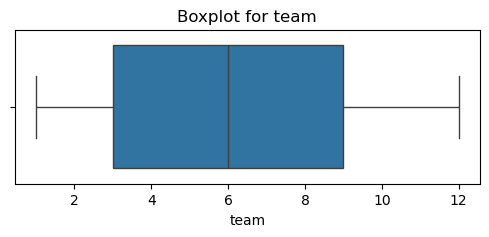

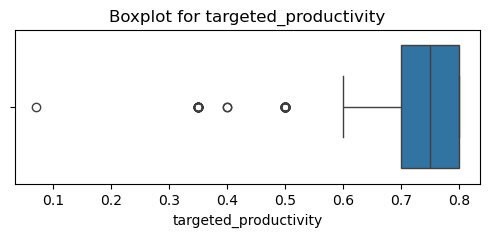

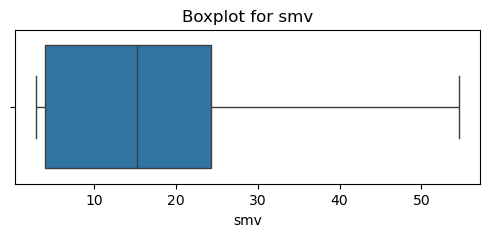

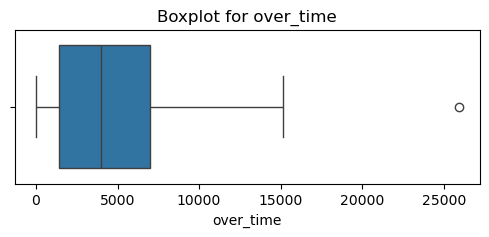

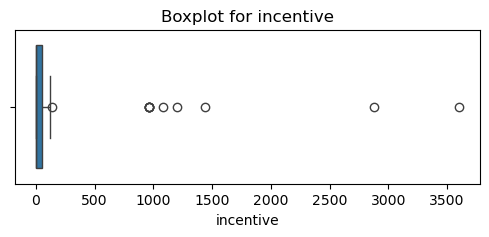

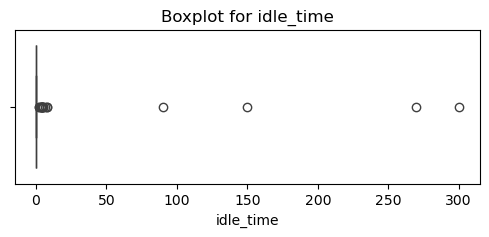

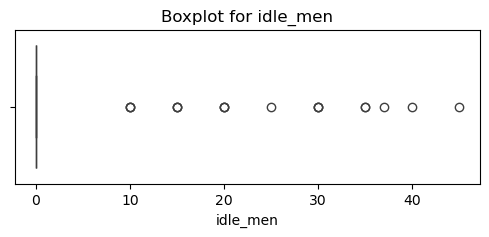

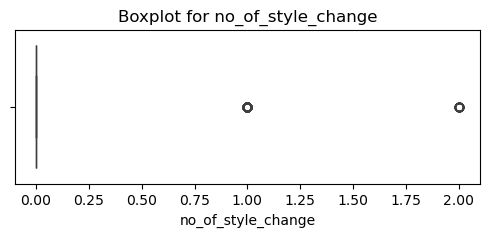

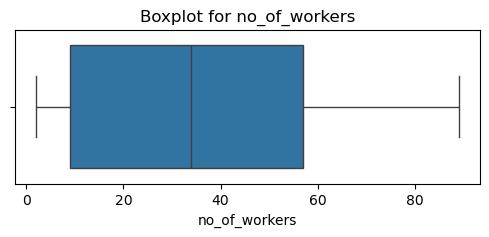

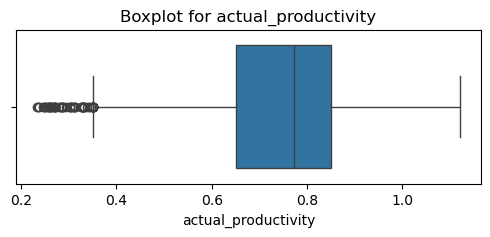


✅ Outliers handled using IQR method — values replaced with **median**.

Before OverSampling, counts of label 'Success': 608
Before OverSampling, counts of label 'Fail': 229
After OverSampling, counts of label 'Success': 608
After OverSampling, counts of label 'Fail': 608


In [1]:
import pandas as pd
file_path = r'C:\Users\ADMIN\Downloads\garments_worker_productivity.csv' 
df=pd.read_csv(file_path)
import matplotlib.pyplot as plt
import seaborn as sns
# Remove leading/trailing spaces in the 'department' column
df['department'] = df['department'].str.strip()

# Get unique values after cleaning
unique_departments = df['department'].unique()

df.head(5)
# Convert 'date' to datetime just in case
df['date'] = pd.to_datetime(df['date'])

# Extract month and day only (to compare mm-dd)
df['mmdd'] = df['date'].dt.strftime('%d-%m')

# Define custom quarters
def assign_custom_quarter(mmdd):
    if '01-01' <= mmdd <= '03-31':
        return 'Q1'
    elif '04-01' <= mmdd <= '06-30':
        return 'Q2'
    elif '07-01' <= mmdd <= '09-30':
        return 'Q3'
    else:
        return 'Q4'

# Apply function to every row
df['quarter'] = df['mmdd'].apply(assign_custom_quarter)

# Optional: Drop mmdd helper column
df.drop(columns=['mmdd'], inplace=True)



# Remove leading/trailing spaces in the 'department' column
df['department'] = df['department'].str.strip()

# Get unique values after cleaning
unique_departments = df['department'].unique()

print(unique_departments)
print(df.columns.tolist())
df.drop(['wip'],axis=1 ,inplace =True)
from sklearn.preprocessing import LabelEncoder

# Create 'success' column
df['success'] = df['actual_productivity'] > df['targeted_productivity']
df['success'] = df['success'].apply(lambda x: 'Success' if x else 'Fail')
# Convert categorical variables to numerical values using one-hot encoding
df = df.drop(columns=['date'])
data_encoded = pd.get_dummies(df, columns=['quarter', 'department', 'day'])
print("\nEncoded Data:")
print(data_encoded.head())
from sklearn.preprocessing import MinMaxScaler

# Step 1: Identify numerical columns
numerical_features = ['team', 'targeted_productivity', 'smv','over_time','incentive',
                      'idle_time','idle_men','no_of_style_change', 'no_of_workers', 'actual_productivity']

# Step 2: Visualize outliers using boxplots (optional)
import seaborn as sns
import matplotlib.pyplot as plt

for feature in numerical_features:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=data_encoded[feature])
    plt.title(f'Boxplot for {feature}')
    plt.show()

# Step 3: Apply IQR and replace outliers with median
for feature in numerical_features:
    Q1 = data_encoded[feature].quantile(0.25)
    Q3 = data_encoded[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_val = data_encoded[feature].median()
    
    # Replace outliers with median
    data_encoded[feature] = data_encoded[feature].apply(
        lambda x: median_val if x < lower_bound or x > upper_bound else x
    )

print("\n✅ Outliers handled using IQR method — values replaced with **median**.\n")
# Split features and target
X = data_encoded.drop(columns=['success'])
y = data_encoded['success']

# Encode target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

print("Before OverSampling, counts of label 'Success':", sum(y_train == 1))
print("Before OverSampling, counts of label 'Fail':", sum(y_train == 0))
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training data
sm = SMOTE(random_state=2)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train.ravel())

# Display class distribution after SMOTE
print("After OverSampling, counts of label 'Success': {}".format(sum(y_train_smote == 1)))
print("After OverSampling, counts of label 'Fail': {}".format(sum(y_train_smote == 0)))

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
def randomforest(X_train_smote, y_train_smote, X_test, y_test):
    
    # Measure training time
    start_time = time.time()
    # Train Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_smote, y_train_smote)
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time (Random Forest before tuning): {training_time:.4f} seconds")
    
    # Predict using Random Forest model
    y_pred_rf = rf_model.predict(X_test)
    y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluate Random Forest model
    print("Random Forest Model")
    print("Accuracy:", accuracy_score(y_test, y_pred_rf))
    print(classification_report(y_test, y_pred_rf))
    print(confusion_matrix(y_test, y_pred_rf))
    
    # Calculate ROC curve and AUC for Random Forest
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    print(roc_auc_rf)
    # Visualize confusion matrix for Random Forest
    ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap=plt.cm.Blues)
    plt.title('Random Forest Confusion Matrix')
    plt.show()
    
    return fpr_rf, tpr_rf, roc_auc_rf


In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def randomforest_after_tuning(X_train_smote, y_train_smote, X_test, y_test):
    # Hyperparameter tuning for Random Forest
    rf_param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'bootstrap': [True, False]
    }
    
    rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                  param_grid=rf_param_grid, 
                                  cv=5, 
                                  n_jobs=-1, 
                                  verbose=1,
                                  scoring='accuracy')
    
    # Measure training time
    start_time = time.time()
    
    rf_grid_search.fit(X_train_smote, y_train_smote)
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time (Random Forest after tuning): {training_time:.4f} seconds")
    
    best_rf_model = rf_grid_search.best_estimator_
    
    # Predict using the best Random Forest model
    y_pred_best_rf = best_rf_model.predict(X_test)
    
    # Evaluate the tuned Random Forest model
    print("Tuned Random Forest Model")
    print("Best Parameters:", rf_grid_search.best_params_)
    print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
    print(classification_report(y_test, y_pred_best_rf))
    print(confusion_matrix(y_test, y_pred_best_rf))
    
    # Calculate ROC curve and AUC for Random Forest
    y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    print(fpr_rf)
    print(tpr_rf)
    print(roc_auc_rf)
    # Visualize confusion matrix for Random Forest
    ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test, y_test, cmap=plt.cm.Blues)
    plt.title('Tuned Random Forest Confusion Matrix')
    plt.show()
    
    return fpr_rf, tpr_rf, roc_auc_rf

Training time (Random Forest before tuning): 0.4536 seconds
Random Forest Model
Accuracy: 0.9305555555555556
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        99
           1       0.96      0.94      0.95       261

    accuracy                           0.93       360
   macro avg       0.91      0.92      0.91       360
weighted avg       0.93      0.93      0.93       360

[[ 90   9]
 [ 16 245]]
0.9732961801927319


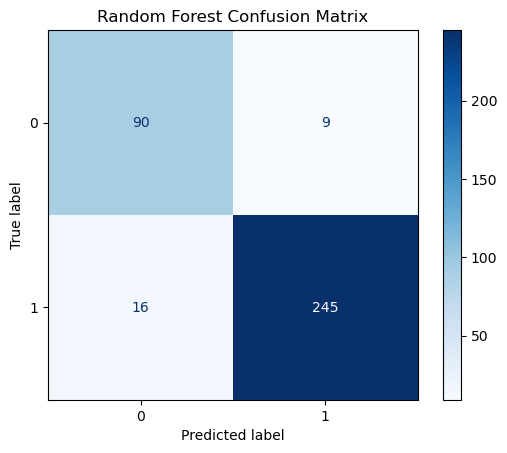

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Training time (Random Forest after tuning): 151.7740 seconds
Tuned Random Forest Model
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Accuracy: 0.9222222222222223
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        99
           1       0.96      0.93      0.95       261

    accuracy                           0.92       360
   macro avg       0.90      0.91      0.90       360
weighted avg       0.92      0.92      0.92       360

[[ 88  11]
 [ 17 244]]
[0.         0.         0.         0.         0.         0.01010101
 0.01010101 0.02020202 0.02020202 0.03030303 0.03030303 0.04040404
 0.04040404 0.06060606 0.06060606 0.07070707 0.07070707 0.08080808
 0.08080808 0.1010101  0.1010101  0.13131313 0.13131313 0.14141414
 0.14141414 0.15151515 0.15151515 0.18181818 0.18181818 0.24242424
 0.24242424 

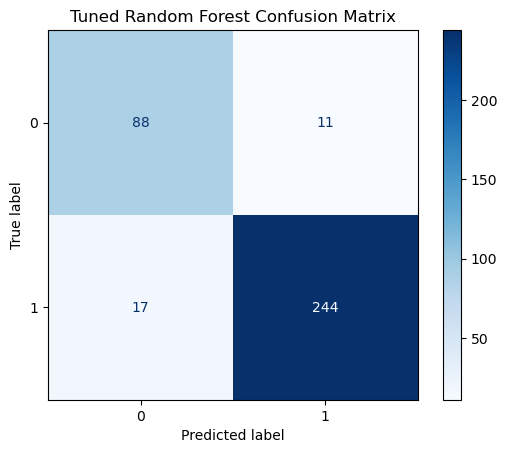

In [4]:
fpr_rf1, tpr_rf1, roc_auc_rf1 = randomforest(X_train_smote, y_train_smote, X_test, y_test)
fpr_rf2, tpr_rf2, roc_auc_rf2 = randomforest_after_tuning(X_train_smote, y_train_smote, X_test, y_test)

Training time (Random Forest before tuning): 0.5389 seconds
Random Forest Model
Accuracy: 0.9305555555555556
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        99
           1       0.96      0.94      0.95       261

    accuracy                           0.93       360
   macro avg       0.91      0.92      0.91       360
weighted avg       0.93      0.93      0.93       360

[[ 90   9]
 [ 16 245]]
0.9732961801927319


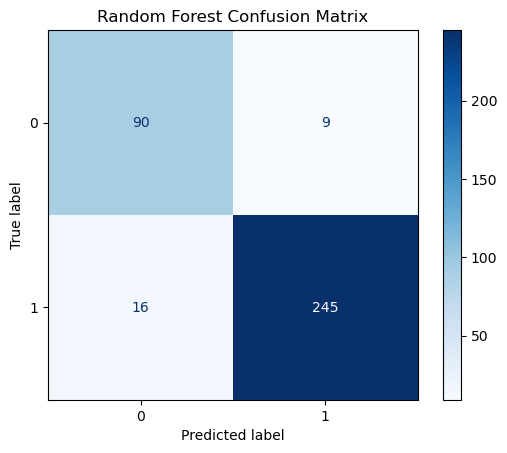

In [5]:
fpr_rf1, tpr_rf1, roc_auc_rf1 = randomforest(X_train_smote, y_train_smote, X_test, y_test)